# Fourth-order PDEs

In [1]:
include("smij-functions.jl");

Consider the **static beam equation**

$$
\partial_{xxxx} u = f(x), \quad u(\pm1) = \partial_x u(\pm1) = 0. 
$$

These are known as *clamped* boundary conditions. If we try to use boundary row removal or replacement as usual, we will have to tamper with rows not just at the boundary, but at interior points as well. This could affect our fidelity to the ODE. 

## Change the variable

One trick (Trefethen's) is to base the spectral method on 

$$
p(x) = (1-x^2)q(x).
$$

Note that $p(\pm1)=0$ regardless of $q$, and $p'(\pm 1)=0$ if we require that $q(\pm1)=0$. Hence we can solve the BVP by using $p^{(4)}(x_j)=f_j$ at the interior points. We will use this to set up constraints on $q$. We can routinely find that

$$
\partial_x^4 p = (1-x^2)\partial_x^4 q - 8x \partial_x^3 q - 12 \partial_x^2 q. 
$$

If $v_j$ are the nodal values of the solution, then the interior nodal values of $q$ are $v_j / (1-x_j^2)$. Hence, the mapping from $v$ to $f$ is 

$$
[\diagm(1-x_i^2) \bfD_x^4 - \diagm(8x_j) \bfD_x^3 - 12 \bfD_x^2] \diagm( 1/(1-x_j^2) ), 
$$

where as usual we only retain rows and columns from 1 to $N$. 


### p38: solve $u_{xxxx} = e^x,\; u(-1)=u(1)=u'(-1)=u'(1)=0$

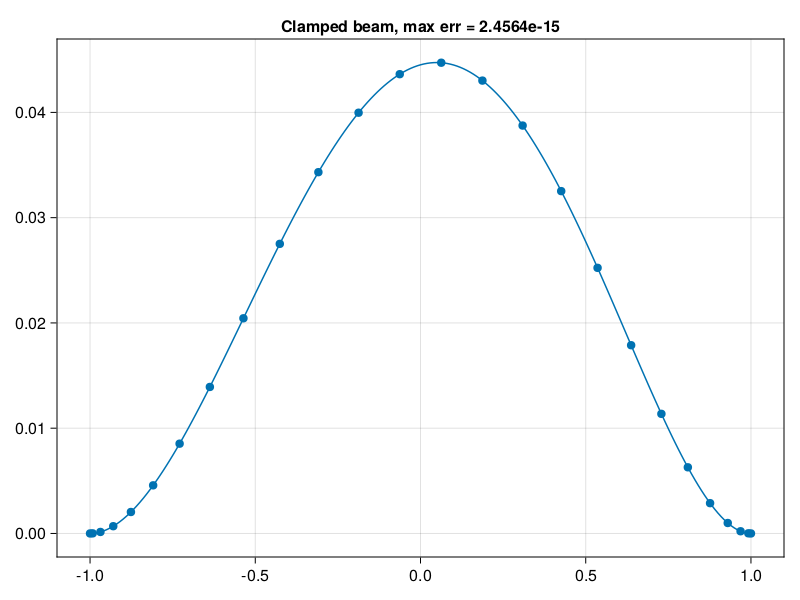

In [2]:
# Construct discrete biharmonic operator:
N = 25

D, x = cheb(N)
s = [1; (@. 1 / (1 - x[2:N]^2)); 1]
L = (diagm(1 .- x.^2)*D^4 - diagm(8x)*D^3 - 12D^2) * diagm(s)
L = L[2:N, 2:N]

f = @. exp(x[2:N])

# Solve boundary-value problem and plot result:
u = [0; L\f; 0]

using CairoMakie, PyFormattedStrings
fig, ax, _ = scatter(x, u)
xx = -1:0.01:1
uu = (@. 1 - xx^2) .* polyinterp(s.*u).(xx)
lines!(xx, uu)

# Determine exact solution and print maximum error:
A = [1 -1 1 -1; 0 1 -2 3; 1 1 1 1; 0 1 2 3]
V = [x^j for x in xx, j in 0:3] 
c = A \ exp.([-1, -1, 1, 1])
exact = exp.(xx) - V * c
ax.title = f"Clamped beam, max err = {norm(uu-exact,Inf):.5g}"
fig

The same kind of transformation works for eigenvalue problems, and in 2D.

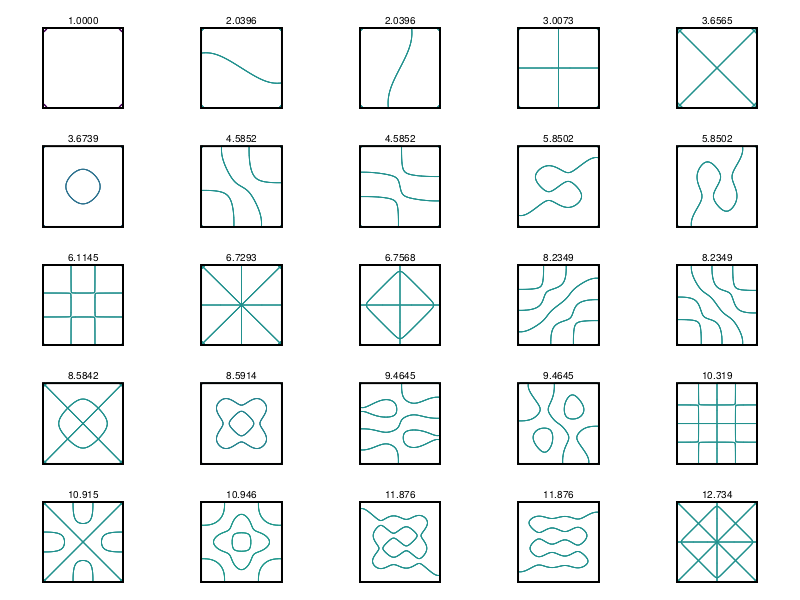

In [3]:
# p39 - eigenmodes of biharmonic on a square with clamped BCs
# Construct spectral approximation to biharmonic operator:
N = 17
D, x = cheb(N)
s = [0; (@. 1 / (1 - x[2:N] ^ 2)); 0]
D4 = (diagm(1 .- x .^ 2) * D^4 - diagm(8x) * D^3 - 12D^2) * diagm(s)
D4 = D4[2:N, 2:N]

D² = (D^2)[2:N, 2:N]
L = kron(I(N-1), D4) + kron(D4, I(N-1)) + 2 * kron(D², I(N-1)) * kron(I(N-1), D²)

# Find and plot 25 eigenmodes:
λ, V = eigen(L)
λ = sqrt.(λ / λ[1])

using Makie.Colors
y = x
xx = yy = -1:0.01:1
sq = Point2.( [(1,1), (-1,1), (-1,-1), (1,-1)] )

fig = Figure()
ax = vec( [ Axis(fig[j,i], aspect=DataAspect()) for i in 1:5, j in 1:5 ] )
U = zeros(N+1, N+1)
for i = 1:25
    U[2:N, 2:N] = reshape(V[:,i], N-1, N-1)
    UU = gridinterp(U, xx, yy)
    contour!(ax[i], xx, yy, UU, levels=[0])
    poly!(ax[i], sq, color=RGBA(1,1,1,0), strokecolor=:black, strokewidth=2)
    hidedecorations!(ax[i])
    hidespines!(ax[i])
    text!(ax[i], 0, 1.05, text=f"{λ[i]:#0.5g}", align=(:center, :bottom), textsize=10 )
    limits!(ax[i], -1.05, 1.05, -1.05, 1.3)
end
fig

<!-- 
```{code-cell}
# p40 - eigenvalues of Orr-Sommerfeld operator (compare p38.jl)
R = 5772
N = 40:20:100
results = []
for N in N
    # 2nd- and 4th-order differentiation matrices:
    D, x = cheb(N)
    D² = (D^2)[2:N, 2:N]
    s = [0; (@. 1 / (1 - x[2:N]^2)); 0]
    D4 = (diagm(1 .- x.^2) * D^4 - diagm(8x) * D^3 - 12D^2) * diagm(s)
    D4 = D4[2:N, 2:N]

    # Orr-Sommerfeld operators A,B and generalized eigenvalues:
    A = (D4 - 2D² + I) / R - 2im * I - 1im * diagm(1 .- x[2:N] .^ 2) * (D² - I)
    B = D² - I
    push!(results, eigvals(A, B))
end

fig = Figure()
ax = vec( [ Axis(fig[j,i], aspect=DataAspect(), xticks=[0]) for i in 1:2, j in 1:2 ] )
for (ax,N,λ) in zip(ax,N,results)
    scatter!(ax, real(λ), imag(λ), markersize=8)
    ax.title = f"max Re(λ) = {maximum(real(λ)):.7g}"
    limits!(ax, -0.8, 0.2, -1, 0)
    text!(ax, -0.7, -0.1, text="N = $N", textsize=14)
end
fig
``` 
-->

## System 

Sometimes we can accommodate these problems by adding an extra variable to create a system of lower order. For example, for the beam equation with *simply supported* boundary conditions,

$$
u(\pm 1) = \partial_x^2 u(\pm1) = 0,
$$

it's natural to introduce $\partial_2 u$ as another variable and solve the system

$$
\begin{bmatrix}
  \partial_x^2 & -1 \\ 0 & \partial_x^2
\end{bmatrix}
\begin{bmatrix}
  u \\ v
\end{bmatrix} = 
\begin{bmatrix}
  0 \\ f
\end{bmatrix}, 
$$

subject to $u(\pm1) = v(\pm 1) = 0$, which can be imposed in our usual way.

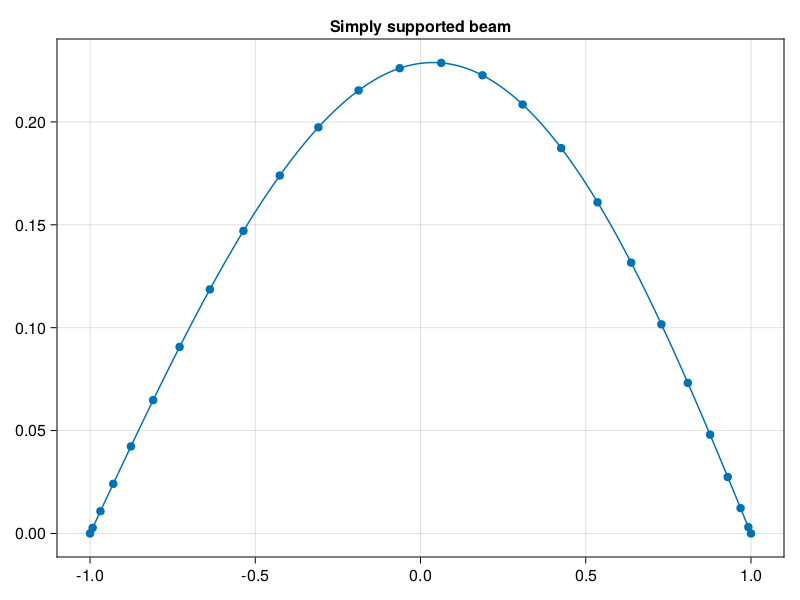

In [4]:
N = 25

D, x = cheb(N)
D² = (D^2)[2:N,2:N]
B = [D² -I; zeros(N-1,N-1) D²]
f = @. exp(x[2:N])

# Solve boundary-value problem and plot result:
w = B \ [0*f; f]
u = [0; w[1:N-1]; 0]

using CairoMakie, PyFormattedStrings
fig, ax, _ = scatter(x, u)
xx = -1:0.01:1
uu = polyinterp(u).(xx)
lines!(xx, uu)
ax.title = "Simply supported beam"
fig

However, attempting the same trick for the original clamped conditions implies the system 

$$
\partial_x u - v &= 0, \\ 
\partial_{xxx} v &= f,
$$

and imposing the boundary conditions at the ends on $v$ isn't enough to prevent the discretization of the third-order derivative from being singular.

## Rectangular discretization

When you consider it carefully, it's rather odd to represent differentiation of polynomials by a square matrix. The matrix $\bfD_x^4$ maps the values of a polynomial interpolant of degree $N$ to the values of its 4th derivative, which has degree $N-4$. We could represent that output on a Chebyshev grid with $N-4+1$ points *without any loss of information*. A quick-and-dirty way to pull that off is to interpolate the values in each column to the smaller Chebyshev grid.

In [5]:
D⁴ = D^4
_, x̃ = cheb(N-4)
D̃4 = hcat( [ polyinterp(d).(x̃) for d in eachcol(D⁴) ]... )
size(D̃4)

(22, 26)

Conveniently, the shape of this new matrix allows us to impose 4 additional boundary conditions in the form of extra rows, creating a square linear system!

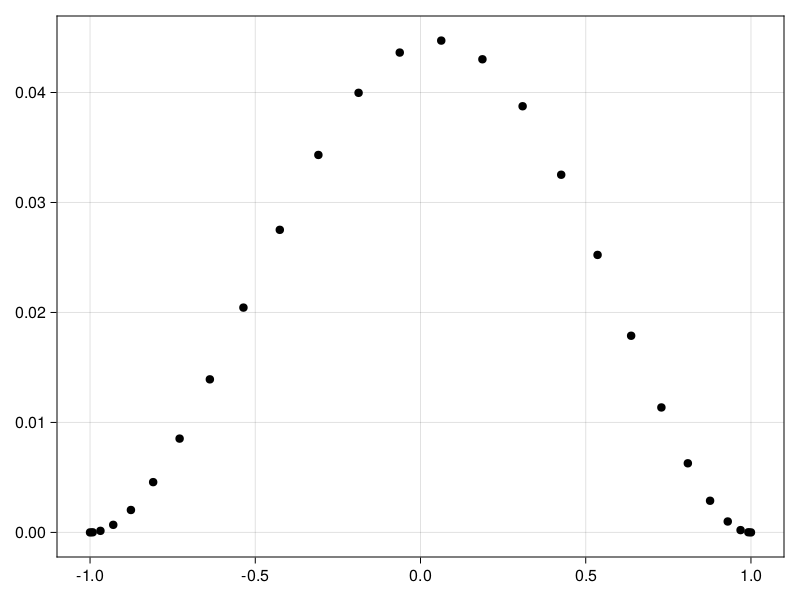

In [6]:
bdy = [1,N+1]
A = [ D̃4; I(N+1)[bdy,:]; D[bdy,:] ]
rhs = [exp.(x̃); zeros(4)]
u = A \ rhs
plot(x,u)